In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, UpSampling3D, Input, ZeroPadding3D, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.layers import Conv3D, MaxPooling3D
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.constraints import unit_norm, max_norm
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
import numpy as np
import nibabel as nib
import scipy as sp
import scipy.ndimage
from sklearn.metrics import mean_squared_error, r2_score

import sys
import argparse
import os
import glob 

import dcor

In [2]:
import pandas as pd
df = pd.read_csv('C:/Users/hgnik/OneDrive/Desktop/Code/confounder-free-cnn/df_labels.csv')
df

,Unnamed: 0,file_name,disease,subcategory,condition,patient_id,eye,sex,year,image_width,image_hight,fil_path,file_path
0,0,amd_1101816_1,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
1,1,amd_1101816_2,1,late,MNV,1101816,OD,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
2,2,amd_1101816_3,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
3,3,amd_1101816_4,1,late,MNV,1101816,OS,F,1941,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
4,4,amd_1191668_1,1,intermediate,MNV_suspected,1191668,OD,F,1948,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,417,no_9054704_2,0,emmetropia,NO,9054704,OD,M,1955,882,318,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
414,418,no_9317962_1,0,emmetropia,NO,9317962,OD,F,1947,882,322,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
415,419,no_9317962_2,0,emmetropia,NO,9317962,OS,F,1947,882,314,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
416,420,no_9663705_1,0,emmetropia,NO,9663705,OD,F,1952,914,291,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...,C:/Users/hgnik/OneDrive/Desktop/Code/confounde...


In [3]:
def augment_by_transformation(data, age, sex, n):
    """
    Augment data by applying transformations.
    
    Args:
    data (ndarray): Input data.
    age (ndarray): Ages corresponding to data samples.
    sex (ndarray): Sexes corresponding to data samples.
    n (int): Desired number of augmented samples.
    
    Returns:
    ndarray: Augmented data.
    ndarray: Augmented ages.
    ndarray: Augmented sexes.
    """
    augment_scale = 1

    if n <= data.shape[0]:
        return data, age, sex
    else:
        raw_n = data.shape[0]
        m = n - raw_n
        # Ensure new_data has the same dimensions as data
        new_data = np.zeros((m, data.shape[1], data.shape[2], data.shape[3], data.shape[4])) if len(data.shape) == 5 else np.zeros((m, data.shape[1], data.shape[2], data.shape[3]))
        for i in range(0, m):
            idx = np.random.randint(0, raw_n)
            new_age = age[idx]
            new_sex = sex[idx]
            new_data[i] = data[idx].copy()
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,0), reshape=False)
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(0,2), reshape=False)
            new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,2), reshape=False)
            new_data[i] = sp.ndimage.shift(new_data[i], np.random.uniform(-0.5, 0.5))

            age = np.append(age, new_age)
            sex = np.append(sex, new_sex)

        data = np.concatenate((data, new_data), axis=0)
        return data, age, sex


### 3D

In [24]:
import numpy as np
import sys
import dcor
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Disable eager execution
tf.compat.v1.disable_eager_execution()

def inv_mse(y_true, y_pred):
    mse_value = K.sum(K.square(y_true-y_pred))
    return -mse_value

def inv_correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)



class GAN():
    
    def __init__(self):
        self.lr = 0.0002
        optimizer = Adam(self.lr)
        optimizer_distiller = Adam(self.lr)
        optimizer_regressor = Adam(self.lr)

        L2_reg = 0.1
        ft_bank_baseline = 16
        latent_dim = 16

        # Build and compile the cf predictorinv_inv
        self.regressor = self.build_regressor()
        self.regressor.compile(loss='mse', optimizer=optimizer)

        input_image = Input(shape=(512, 512, 512, 1), name='input_image')
        feature = Conv3D(ft_bank_baseline, activation='relu', kernel_size=(3, 3, 3), padding='same')(input_image)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)  # Less aggressive pooling

        feature = Conv3D(ft_bank_baseline*2, activation='relu', kernel_size=(3, 3, 3), padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature = Conv3D(ft_bank_baseline*4, activation='relu', kernel_size=(3, 3, 3), padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature = Conv3D(ft_bank_baseline*2, activation='relu', kernel_size=(3, 3, 3), padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling3D(pool_size=(2, 2, 2))(feature)

        feature_dense = Flatten()(feature)

        # Add a Dense layer to adjust the output dimensionality precisely to 1024
        feature_dense = Dense(1024, activation='relu')(feature_dense)
        print("Flatten output shape:", feature_dense.shape)  # Check the output shape again
        self.encoder = Model(input_image, feature_dense)




        # For the distillation model we will only train the encoder

        self.regressor.trainable = False
        cf = self.regressor(feature_dense)
        self.distiller = Model(input_image, cf)
        self.distiller.compile(loss=inv_correlation_coefficient_loss, optimizer=optimizer)

        # Build and Compile the classifer  
        input_feature_clf = Input(shape=(1024,), name='input_feature_dense')
        feature_clf = Dense(latent_dim*4, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(input_feature_clf)
        feature_clf = Dense(latent_dim*2, activation='tanh',kernel_regularizer=regularizers.l2(L2_reg))(feature_clf)
        prediction_score = Dense(1, name='prediction_score',kernel_regularizer=regularizers.l2(L2_reg))(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)

        # Build the entir workflow
        prediction_score_workflow = self.classifier(feature_dense)
        label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
        self.workflow = Model(input_image, label_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])


    def build_regressor(self):
        latent_dim = 16
        inputs_x = Input(shape=(1024,))
        feature = Dense(latent_dim*4, activation='tanh')(inputs_x)
        feature = Dense(latent_dim*2, activation='tanh')(feature)
        cf = Dense(1)(feature)

        return Model(inputs_x, cf)
    
    def train(self, epochs, training, testing, testing_raw, batch_size=256, fold=0):
        print('we are inside the training function now')
        [train_data_aug, train_dx_aug, train_age_aug, train_sex_aug] = training
        [test_data_aug, test_dx_aug, test_age_aug, test_sex_aug] = testing
        [test_data, test_dx, test_age, test_sex] = testing_raw
        
        test_data_aug_flip = np.flip(test_data_aug, axis=2)
        test_data_flip = np.flip(test_data, axis=2)

        dc_age = np.zeros((int(epochs/10)+1,))
        min_dc = 0
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs} started.")
            idx_perm = np.random.permutation(int(train_data_aug.shape[0]))
            for i in range(0, len(train_data_aug), batch_size):
                idx = idx_perm[i:i + batch_size]
                print(f"Processing batch {i//batch_size + 1}/{len(train_data_aug)//batch_size} for epoch {epoch+1}.")
                training_feature_batch = train_data_aug[idx]
                dx_batch = train_dx_aug[idx]
                age_batch = train_age_aug[idx]

                # # Check if reshaping is needed
                # if training_feature_batch.shape != (batch_size, 512, 512, 512, 1):
                #     continue  # Skip processing if the batch shape is incorrect, or implement a correction mechanism

                training_feature_ctrl_batch = train_data_aug[idx_perm[:batch_size]]
                age_ctrl_batch = train_age_aug[idx_perm[:batch_size]]

                # Train regressor (cf predictor)
                encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
                r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, age_ctrl_batch)

                # Train Distiller
                g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch, age_ctrl_batch)
                
                # Train Encoder & Classifier
                c_loss = self.workflow.train_on_batch(training_feature_batch, dx_batch)

                # Flip & re-do everything
                training_feature_batch_flip = np.flip(training_feature_batch, axis=2)
                training_feature_ctrl_batch_flip = np.flip(training_feature_ctrl_batch, axis=2)

                encoded_feature_ctrl_batch_flip = self.encoder.predict(training_feature_ctrl_batch_flip)
                r_loss_flip = self.regressor.train_on_batch(encoded_feature_ctrl_batch_flip, age_ctrl_batch)
                g_loss_flip = self.distiller.train_on_batch(training_feature_ctrl_batch_flip, age_ctrl_batch)
                c_loss_flip = self.workflow.train_on_batch(training_feature_batch_flip, dx_batch)

                # Logging and saving model weights
                if epoch % 50 == 0:
                    print(f"Evaluating model at epoch {epoch}...")
                    c_loss_test_1 = self.workflow.evaluate(test_data_aug, test_dx_aug, verbose=0, batch_size=batch_size)    
                    c_loss_test_2 = self.workflow.evaluate(test_data_aug_flip, test_dx_aug, verbose=0, batch_size=batch_size)    

                    features_dense = self.encoder.predict(train_data_aug[train_dx_aug == 0], batch_size=batch_size)
                    dc_age[int(epoch/10)] = dcor.u_distance_correlation_sqr(features_dense, train_age_aug[train_dx_aug == 0])
                    print ("%d [Acc: %f,  Test Acc: %f %f,  dc: %f]" % (epoch, c_loss[1], c_loss_test_1[1], c_loss_test_2[1], dc_age[int(epoch/10)]))
                    sys.stdout.flush()

                    self.classifier.save_weights("res_cf_5cv/classifier.h5")
                    self.encoder.save_weights("res_cf_5cv/encoder.h5")
                    self.workflow.save_weights("res_cf_5cv/workflow.h5")

                    prediction = self.workflow.predict(test_data, batch_size=batch_size)
                    filename = 'res_cf_5cv/prediction_'+str(fold)+'_'+str(epoch)+'.txt'
                    np.savetxt(filename, prediction)
                    prediction = self.workflow.predict(test_data_flip, batch_size=batch_size)
                    filename = 'res_cf_5cv/prediction_flip_'+str(fold)+'_'+str(epoch)+'.txt'
                    np.savetxt(filename, prediction)

                    filename = 'res_cf_5cv/dx_'+str(fold)+'.txt'
                    np.savetxt(filename, test_dx)    
                    filename = 'res_cf_5cv/cf_'+str(fold)+'.txt'
                    np.savetxt(filename, test_age)
                    print(f"Epoch {epoch}: Test Acc original data: {c_loss_test_1[1]*100}%, flipped data: {c_loss_test_2[1]*100}%.")





### 2D

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Custom loss function for inverse correlation coefficient
def inv_correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = tf.reduce_mean(x)
    my = tf.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.reduce_sum(tf.multiply(xm, ym))
    r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(xm)), tf.reduce_sum(tf.square(ym)))) + 1e-5
    r = r_num / r_den
    r = tf.maximum(tf.minimum(r, 1.0), -1.0)
    return 1 - tf.square(r)

class GAN:
    def __init__(self):
        self.lr = 0.0002
        self.optimizer = Adam(self.lr)

        # Building the encoder model
        input_image = Input(shape=(512, 512, 3), name='input_image')
        feature = Conv2D(16, (3, 3), activation='relu', padding='same')(input_image)
        feature = BatchNormalization()(feature)
        feature = MaxPooling2D((2, 2))(feature)
        feature = Conv2D(32, (3, 3), activation='relu', padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling2D((2, 2))(feature)
        feature = Conv2D(64, (3, 3), activation='relu', padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling2D((2, 2))(feature)
        feature = Conv2D(32, (3, 3), activation='relu', padding='same')(feature)
        feature = BatchNormalization()(feature)
        feature = MaxPooling2D((2, 2))(feature)
        feature_dense = Flatten()(feature)
        feature_dense = Dense(1024, activation='relu')(feature_dense)
        self.encoder = Model(input_image, feature_dense)

        # Building the regressor model
        self.regressor = self.build_regressor()
        self.regressor.compile(loss='mse', optimizer=self.optimizer)

        # Distiller model to adjust features processed by the encoder
        self.regressor.trainable = False
        cf = self.regressor(feature_dense)
        self.distiller = Model(input_image, cf)
        self.distiller.compile(loss=inv_correlation_coefficient_loss, optimizer=self.optimizer)

        # Classifier model
        input_feature_clf = Input(shape=(1024,), name='input_feature_dense')
        feature_clf = Dense(64, activation='tanh')(input_feature_clf)
        feature_clf = Dense(32, activation='tanh')(feature_clf)
        prediction_score = Dense(1, activation='sigmoid')(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)
        self.classifier.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        # Connecting all components in the workflow
        prediction_score_workflow = self.classifier(self.distiller(feature_dense))
        self.workflow = Model(input_image, prediction_score_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

    def build_regressor(self):
        inputs_x = Input(shape=(1024,))
        feature = Dense(64, activation='tanh')(inputs_x)
        feature = Dense(32, activation='tanh')(feature)
        cf = Dense(1)(feature)
        return Model(inputs_x, cf)

    def train(self, epochs, training, testing, testing_raw, batch_size=64, fold=0):
        [train_data, train_labels, train_age, train_sex] = training
        [test_data, test_labels, test_age, test_sex] = testing

        for epoch in range(epochs):
            print(f"Epoch {epoch+1} of {epochs}")
            idx_perm = np.random.permutation(len(train_data))
            for i in range(0, len(train_data), batch_size):
                idx = idx_perm[i:i + batch_size]
                batch_images = train_data[idx]
                batch_labels = train_labels[idx]

                with tf.GradientTape() as tape:
                    predictions = self.workflow(batch_images, training=True)
                    loss = tf.keras.losses.binary_crossentropy(batch_labels, predictions)

                gradients = tape.gradient(loss, self.workflow.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.workflow.trainable_variables))

                if i % 10 == 0:
                    eval_metrics = self.workflow.evaluate(test_data, test_labels, batch_size=batch_size, verbose=0)
                    print(f"Batch {i//batch_size + 1}: Loss = {eval_metrics[0]}, Accuracy = {eval_metrics[1]}")

            if epoch % 10 == 0:
                self.workflow.save_weights(f"gan_model_weights_{fold}_{epoch}.h5")

        print('Training complete.')

In [28]:
import numpy as np
import cv2  # or use Pillow for image loading
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm


# Assuming you have a DataFrame named df containing image paths, sex, age, and labels

def load_image(image_path):
    """Load image using OpenCV"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load image in color mode
    # You can also use Pillow if you prefer: img = Image.open(image_path)
    return img

if __name__ == '__main__':
    # Load data from DataFrame
    file_idx = df['file_path'].values
    age = df['year'].values
    sex = df['sex'].values
    labels = df['disease'].values

    np.random.seed(seed=0)

    subject_num = len(file_idx)
    patch_x = 512  # Adjusted to match image dimensions
    patch_y = 512  # Adjusted to match image dimensions
    min_x = 0
    min_y = 0

    augment_size = 512
    data = np.zeros((subject_num, patch_x, patch_y, 3))  # Changed to 3 channels for color images
    i = 0
    for subject_idx in tqdm(range(len(file_idx))):
        filename_full = file_idx[subject_idx]

        # Load image
        img = load_image(filename_full)
        img_data = img[min_x:min_x+patch_x, min_y:min_y+patch_y]
        data[i] = (img_data - np.mean(img_data)) / np.std(img_data)  # Normalize image data

        i += 1

    # Depth of the image
    depth = data.shape[-1]

    # Separate data into positive and negative instances
    positive_data = data[labels == 1]
    negative_data = data[labels == 0]
    positive_age = age[labels == 1]
    negative_age = age[labels == 0]
    positive_sex = sex[labels == 1]
    negative_sex = sex[labels == 0]
    # Augment data for positive and negative instances separately
    positive_data_aug, positive_age_aug, positive_sex_aug = augment_by_transformation(positive_data, positive_age, positive_sex, augment_size)
    negative_data_aug, negative_age_aug, negative_sex_aug = augment_by_transformation(negative_data, negative_age, negative_sex, augment_size)

    # Concatenate augmented data
    data_aug = np.concatenate((positive_data_aug, negative_data_aug), axis=0)
    age_aug = np.concatenate((positive_age_aug, negative_age_aug), axis=0)
    sex_aug = np.concatenate((positive_sex_aug, negative_sex_aug), axis=0)
    labels_aug = np.concatenate((np.ones(positive_data_aug.shape[0]), np.zeros(negative_data_aug.shape[0])), axis=0)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    pred = np.zeros((labels_aug.shape))

    fold = 1
    for train_idx, test_idx in skf.split(data_aug, labels_aug):
        if fold < 3:
            fold = fold + 1
            continue

        train_data = data_aug[train_idx]
        train_labels = labels_aug[train_idx]
        train_age = age_aug[train_idx]
        train_sex = sex_aug[train_idx]

        test_data = data_aug[test_idx]
        test_labels = labels_aug[test_idx]
        test_age = age_aug[test_idx]
        test_sex = sex_aug[test_idx]

        print('begin training')

        sys.stdout.flush()
        gan = GAN()
        gan.train(epochs=10, training=[train_data, train_labels, train_age, train_sex], testing=[test_data, test_labels, test_age, test_sex], testing_raw=[test_data, test_labels, test_age, test_sex], batch_size=64, fold=fold)

        fold = fold + 1


  0%|          | 0/418 [00:00<?, ?it/s]

100%|██████████| 418/418 [00:04<00:00, 84.42it/s]
C:\Users\hgnik\AppData\Local\Temp\ipykernel_32224\3034005116.py:30: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,0), reshape=False)
C:\Users\hgnik\AppData\Local\Temp\ipykernel_32224\3034005116.py:31: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(0,2), reshape=False)
C:\Users\hgnik\AppData\Local\Temp\ipykernel_32224\3034005116.py:32: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  new_data[i] = sp.ndimage.interpolation.rotate(new_data[i], np.random.uniform(-0.5, 0.5), axes=(1,2), re

begin training


ValueError: Input 0 of layer "model_16" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(None, 1024)

In [23]:

pip show tensorflow

Name: tensorflowNote: you may need to restart the kernel to use updated packages.

Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\Users\hgnik\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [7]:
import cv2

# Load one of your 3D images
image_path = df['file_path'][0]
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load the image without changing its depth

# Get the shape of the image
depth = image.shape[2]  # The depth corresponds to the third dimension of the shape

print("Depth of the image:", depth)

Depth of the image: 3


In [8]:
print("Shape of labels:", labels.shape)
print("Shape of data_aug:", data_aug.shape)

Shape of labels: (418,)
Shape of data_aug: (1024, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of augmented positive data: (512, 512, 512, 3)
Shape of augmented negative data: (512, 512, 512, 3)
Shape of augmented age: (1024,)
Shape of augmented sex: (1024,)
Shape of augmented labels: (1024,)
Visualizing some of the augmented images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


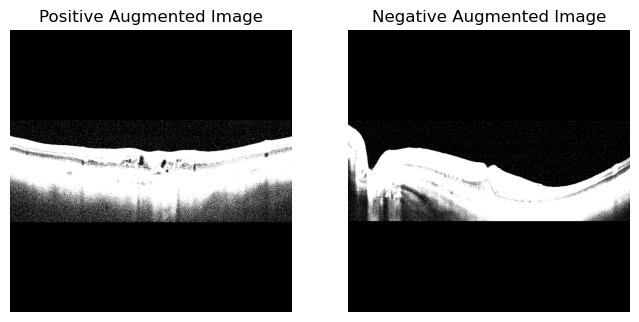

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


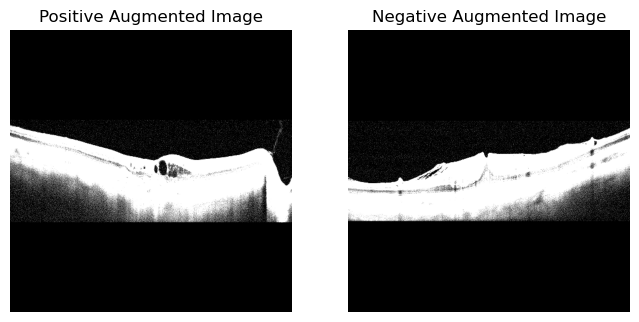

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


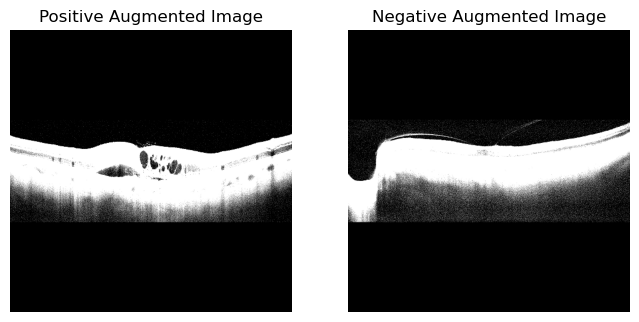

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


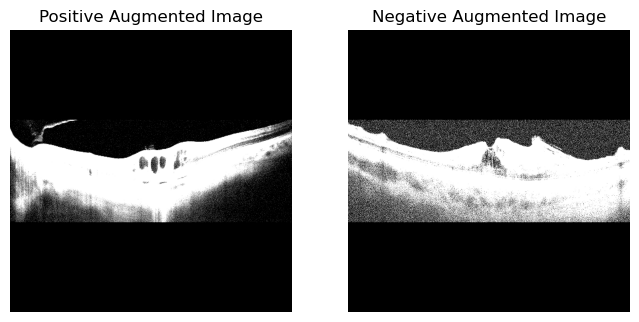

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


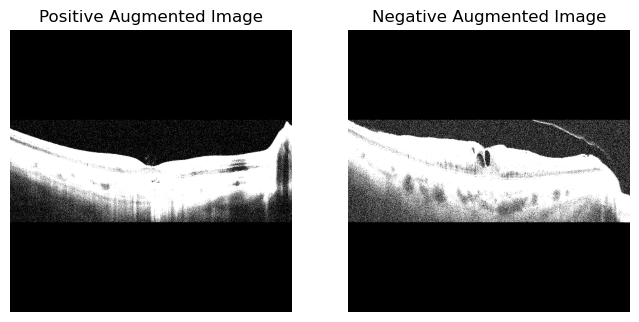

Length whole data: 1024
Length test data: 205
Length train data: 819


In [9]:
import matplotlib.pyplot as plt

# Check the shape of augmented data
print("Shape of augmented positive data:", positive_data_aug.shape)
print("Shape of augmented negative data:", negative_data_aug.shape)
print("Shape of augmented age:", age_aug.shape)
print("Shape of augmented sex:", sex_aug.shape)
print("Shape of augmented labels:", labels_aug.shape)

# Visualize some of the augmented images
n_samples_to_visualize = 5

print("Visualizing some of the augmented images:")
for i in range(n_samples_to_visualize):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(positive_data_aug[i].squeeze(), cmap='gray')
    plt.title("Positive Augmented Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(negative_data_aug[i].squeeze(), cmap='gray')
    plt.title("Negative Augmented Image")
    plt.axis('off')

    plt.show()


print("Length whole data:", len(data_aug))
print("Length test data:", len(test_data))
print("Length train data:", len(train_data))


In [13]:
import cv2

def load_image(image_path):
    """Load an image from the path in RGB format."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as a color image
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return img_rgb

def verify_image(image, expected_shape=(512, 512, 3)):
    if image.shape != expected_shape:
        raise ValueError(f"Unexpected image shape: {image.shape}. Expected shape was {expected_shape}.")
    print(f"Image shape verified: {image.shape}")  # Optional: Confirm shape in the output


In [14]:
df['file_path']

0      C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
1      C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
2      C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
3      C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
4      C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
                             ...                        
413    C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
414    C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
415    C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
416    C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
417    C:/Users/hgnik/OneDrive/Desktop/Code/confounde...
Name: file_path, Length: 418, dtype: object

In [15]:
import numpy as np
from tqdm import tqdm

# Assuming `file_paths` is a list of image file paths
file_paths = df['file_path']

data = []
for file_path in tqdm(file_paths):
    img_rgb = load_image(file_path)
    verify_image(img_rgb, expected_shape=(512, 512, 3))  # Assuming you expect 512x512 RGB images
    data.append(img_rgb)  # Add the verified image to your dataset

data = np.array(data)  # Convert list to a NumPy array for further processing
print("All images loaded and verified.")


 13%|█▎        | 55/418 [00:00<00:01, 281.00it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

 28%|██▊       | 119/418 [00:00<00:00, 304.52it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

 44%|████▍     | 185/418 [00:00<00:00, 316.34it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

 59%|█████▉    | 247/418 [00:00<00:00, 289.79it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

 74%|███████▍  | 311/418 [00:01<00:00, 303.25it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

 90%|█████████ | 377/418 [00:01<00:00, 315.16it/s]

Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 

100%|██████████| 418/418 [00:01<00:00, 303.04it/s]


Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
Image shape verified: (512, 512, 3)
All images loaded and verified.


In [20]:
for i in data_aug :
    if i.shape != (512, 512, 3):
        print('problem found')